# Introduction <a name="introduction"></a>
The Premier League is the most-watched professional soccer league on the planet.

## Model Overview <a name="model-overview"></a>
In the hopes of predicting the outcome of individual games, we considered data from the Premier League's official website on game-level statistics and aggregated financial information regarding teams transfer business. 

### Multi-class Model
Firstly, we consider a simple multi-class model where for each game there were 3 potential outcomes ($y$) where

$$
y = \cases{-1 \,if\,away\,team\,wins\\ 
            0 \,draw\\
            1 \,if\,home\,team\,wins}
$$

This is a transformed variable that we will calculate using a `score_to_win()` function provided in our `helper` suite. 

#### Prepare Data

In [4]:
import pandas as pd
from helpers import *
%matplotlib inline

# to supress warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
DATA_SRC = '../Data/PL_site_2006_2018/masterdata.csv'
df = pd.read_csv(DATA_SRC)

# create win/lose label
df['target'] = df[['Score_home', 'Score_away']].apply(score_to_win, axis = 1)
df.sort_values('MatchID', inplace = True)
df.head()

,MatchID,Home_team,Away_team,Score_home,Score_away,Possession_home,Possession_away,Shots_on_target_home,Shots_on_target_away,Shots_home,...,year,Expenditures_home,Arrivals_home,Income_home,Departures_home,Expenditures_away,Arrivals_away,Income_away,Departures_away,target
373,5567,Arsenal,Aston Villa,1,1,72.9,27.1,7,3,24,...,2007,17.10,18,14.85,21,28.16,17,2.08,18,0
379,5568,Bolton,Spurs,2,0,37.8,62.2,4,2,13,...,2007,19.38,16,4.39,16,69.54,23,44.06,23,1
374,5569,Everton,Watford,2,1,47.0,53.0,2,7,8,...,2007,20.41,11,2.85,16,11.97,29,15.39,23,1
375,5570,Newcastle,Wigan,2,1,55.3,44.7,5,4,8,...,2007,36.34,8,12.74,14,29.24,23,27.73,25,1
376,5571,Portsmouth,Blackburn,3,0,44.3,55.7,11,3,21,...,2007,10.37,28,1.43,32,18.84,21,19.28,25,1


In order to fit our model appropriately, we have to consider an $X$ matrix of values that has no information regarding our target variables. So, here we will drop the features that might provide the model information on $y$, i.e. `MatchID`, `Home_team`, `Away_team`, `Score_home`, `Score_away`, and `year` along with our `target`. 

In [42]:
FEATURES_TO_DROP = ['target', 'MatchID', 'Home_team', 'Away_team', 'Score_home', 'Score_away', 'year']
df_wo = df.drop(columns = FEATURES_TO_DROP)

### EDA
Prior to setting up any model it's important to visualize the features of our data so that we can get a sense of what might work. Firstly, we'll visualize the pair-wise correlation of variables. Given that the game-stats are symmetric (each home & away team has a value) we'll just investigate the home-team features.

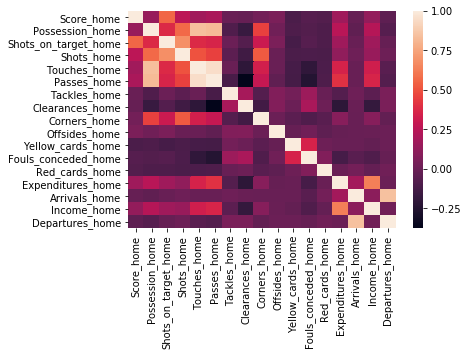

In [43]:
import seaborn as sns
home_features = [ f for f in list(df) if '_home' in f ]
corr = df[home_features].corr()
_ = sns.heatmap(corr)

Our target, `Score_home` seems to be most correlated with `Shots_on_target_home`. This makes some intuitive sense, the more shots you get on goal, obviously the more likely you are to score. Otherwise, it appears a lot of our other available variables are not too correlated with our target. There do appear to exist some groups of variables that may be capturing similar information. E.g. is `Posession_home` measuring anything different from `Touches_home`?

Now, let's investigate their various distributions.

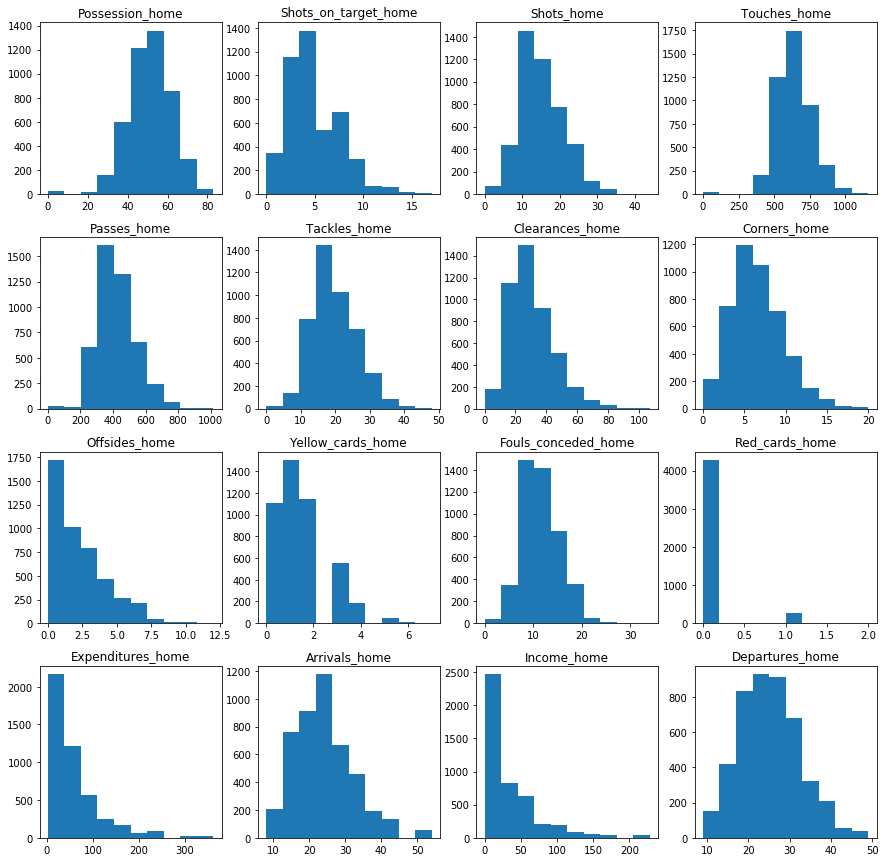

In [45]:
import matplotlib.pyplot as plt
n_figs = len(home_features)
columns = 4

fig, axes = plt.subplots(int(n_figs/columns), columns, figsize = (15, 15))
plt.subplots_adjust(hspace = .25)

home_features = [ f for f in list(df_wo) if '_home' in f ]
for i, feature in enumerate(home_features):
    row = int(i / columns)
    column = i % columns
    axes[row, column].hist(df[feature].values)
    axes[row, column].set_title(feature)

What about the distribution of our target variable?

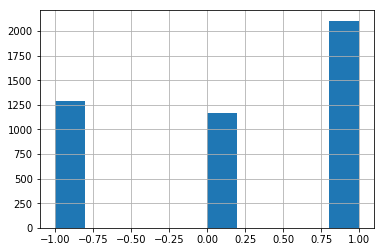

In [46]:
_ = df.target.hist()

Seems like being the home team within a specific game it crucial, so we'll need to remember that later when constructing our models.

Now we said `Shots_on_target_home` contained some information regarding our target-by-proxy `Score_home`. Let's investigate that relationship.

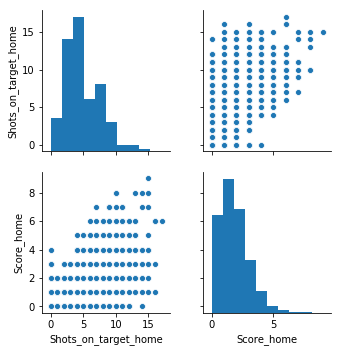

In [47]:
_ = sns.pairplot(df[['Shots_on_target_home', 'Score_home']])

# <a name = "feature-selection"></a> Feature Selection 
As established, we have a full set of features but should be concerned about potential overlap within that feature set. A model containing overlapping (collinear) features will be unnecessarily complex. This could lead to (1) higher out-of-sample error (i.e. on our testing set) and (2) a lack of interpretability for a null benefit. So, let's do some further investigation in the hopes that we can cull some features out of our model(s).

## Feature Importance
### Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df_wo.values
y = df['target'].values
features = df_wo.columns
forest = RandomForestClassifier(n_estimators=500,random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, 
                                                                random_state = 42)

forest.fit(X_train, y_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
indices
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,features[indices[f]], importances[indices[f]]))

 1) Shots_on_target_home           0.070598
 2) Clearances_away                0.063984
 3) Shots_on_target_away           0.061514
 4) Clearances_home                0.050045
 5) Expenditures_away              0.038348
 6) Expenditures_home              0.037344
 7) Passes_away                    0.037064
 8) Touches_away                   0.036100
 9) Passes_home                    0.035598
10) Income_away                    0.035050
11) Income_home                    0.034176
12) Touches_home                   0.033785
13) Shots_away                     0.031355
14) Shots_home                     0.031181
15) Possession_away                0.030172
16) Possession_home                0.029506
17) Tackles_home                   0.028810
18) Arrivals_away                  0.028300
19) Tackles_away                   0.028192
20) Departures_home                0.027429
21) Arrivals_home                  0.027124
22) Departures_away                0.027055
23) Fouls_conceded_away         

This confirms some of our former intuition. `Shots_on_target_*` are an important feature. Others, particularly `Expenditures_*`, are also noteworthy.

### Sequential Backward Selection
Now, let's perform some model fitting using Sequential Backward Selection (i.e. tossing out variables one at at time) to further investigate feature importance.

In [49]:
from SBS import *
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [50]:
lr = LogisticRegression()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
knn = KNeighborsClassifier()

clf_labels = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'KNN']

all_clf = [lr, rf, gb, knn]

In [51]:
k_feat = {key: None for key in clf_labels}
sbs = {key: None for key in clf_labels}

sbs

{'Logistic Regression': None,
 'Random Forest': None,
 'Gradient Boosting': None,
 'KNN': None}

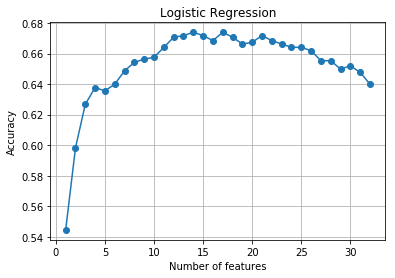

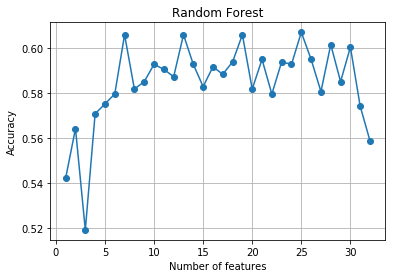

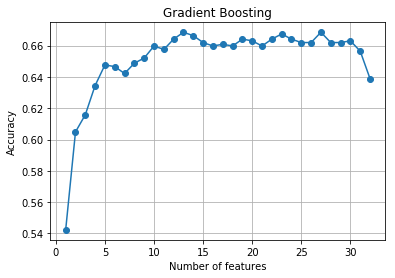

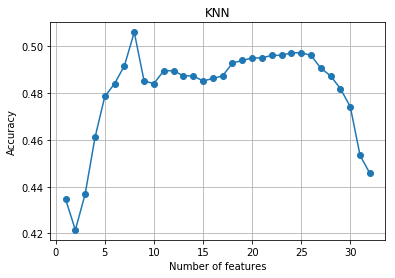

In [53]:
# NOTE: this step will take 10 minutes to run!
import matplotlib.pyplot as plt

for label, clf in zip(clf_labels, all_clf):
    sbs[label] = SBS(clf,k_features=1)
    sbs[label].fit(X_train,y_train)
    k_feat[label] = [len(k) for k in sbs[label].subsets_]
    plt.plot(k_feat[label], sbs[label].scores_, marker='o')
    #plt.ylim([0.3, 1.02])
    plt.title(label)
    plt.ylabel('Accuracy')
    plt.xlabel('Number of features')
    plt.grid()
    plt.show()

In [54]:
lr_features = list(sbs['Logistic Regression'].subsets_[20])
for idx, i in enumerate(lr_features):
    print(idx,features[i]) 

0 Possession_home
1 Possession_away
2 Shots_on_target_home
3 Shots_on_target_away
4 Shots_home
5 Touches_home
6 Touches_away
7 Tackles_away
8 Clearances_home
9 Clearances_away
10 Income_home
11 Expenditures_away


In [55]:
rf_features = list(sbs['Random Forest'].subsets_[13])
for idx, i in enumerate(rf_features):
    print(idx,features[i]) 

0 Possession_home
1 Shots_on_target_home
2 Shots_on_target_away
3 Shots_home
4 Touches_away
5 Tackles_away
6 Clearances_home
7 Clearances_away
8 Offsides_home
9 Offsides_away
10 Yellow_cards_away
11 Fouls_conceded_home
12 Red_cards_home
13 Red_cards_away
14 Arrivals_home
15 Income_home
16 Departures_home
17 Expenditures_away
18 Income_away


In [56]:
gb_features = list(sbs['Gradient Boosting'].subsets_[18])
for idx, i in enumerate(gb_features):
    print(idx,features[i]) 

0 Possession_home
1 Shots_on_target_home
2 Shots_on_target_away
3 Touches_home
4 Passes_away
5 Tackles_home
6 Clearances_home
7 Clearances_away
8 Corners_home
9 Corners_away
10 Yellow_cards_away
11 Departures_home
12 Expenditures_away
13 Departures_away


In [57]:
knn_features = list(sbs['KNN'].subsets_[26])
for idx, i in enumerate(knn_features):
    print(idx,features[i]) 

0 Touches_away
1 Clearances_home
2 Clearances_away
3 Arrivals_home
4 Income_home
5 Expenditures_away


In [61]:
for clf in all_clf:
    clf.fit(X_train, y_train)
    print(type(clf))
    print("score = ", clf.score(X_test, y_test), "\n")

<class 'sklearn.linear_model.logistic.LogisticRegression'>
score =  0.6513157894736842 

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
score =  0.5800438596491229 

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
score =  0.6348684210526315 

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
score =  0.47478070175438597 



In [62]:
lr.fit(X_train[:, lr_features], y_train)
print('Train accuracy:', lr.score(X_train[:, lr_features], y_train))
print('Test accuracy:', lr.score(X_test[:, lr_features], y_test))

Train accuracy: 0.6309001097694841
Test accuracy: 0.643640350877193


In [63]:
rf.fit(X_train[:, rf_features], y_train)
print('Train accuracy:', rf.score(X_train[:, rf_features], y_train))
print('Test accuracy:', rf.score(X_test[:, rf_features], y_test))

Train accuracy: 0.9898463227222832
Test accuracy: 0.5833333333333334


In [64]:
gb.fit(X_train[:, gb_features], y_train)
print('Train accuracy:', gb.score(X_train[:, gb_features], y_train))
print('Test accuracy:', gb.score(X_test[:, gb_features], y_test))

Train accuracy: 0.7280461031833151
Test accuracy: 0.6337719298245614


In [65]:
knn.fit(X_train[:, knn_features], y_train)
print('Train accuracy:', knn.score(X_train[:, knn_features], y_train))
print('Test accuracy:', knn.score(X_test[:, knn_features], y_test))

Train accuracy: 0.6473655323819978
Test accuracy: 0.48355263157894735


#### Checking the performance of the selected features
It seems like using the selected features can improve test accuracy for KNN classifier

In [66]:
knn.fit(X_train, y_train)
print('Training accuracy:', knn.score(X_train, y_train))
print('Test accuracy:', knn.score(X_test, y_test))

Training accuracy: 0.6451701427003294
Test accuracy: 0.47478070175438597


In [67]:
knn.fit(X_train[:, k14], y_train)
print('Training accuracy:', knn.score(X_train[:, k14], y_train))
print('Test accuracy:', knn.score(X_train[:, k14], y_train))

Training accuracy: 0.6424259055982436
Test accuracy: 0.6424259055982436


### PCA

In [68]:
from PlotDecisionRegions import *
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

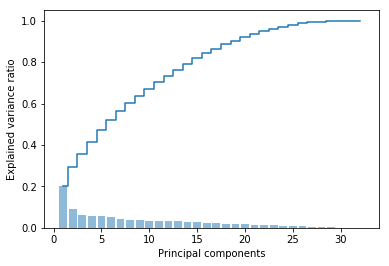

In [69]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
# pca.explained_variance_ratio_
plt.bar(range(1, 33), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 33), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

In [72]:
pca = PCA(n_components = 15)

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

for clf in all_clf:
    clf.fit(X_train_pca, y_train)
    print(type(clf))
    print("score = ", clf.score(X_test_pca, y_test), "\n")

<class 'sklearn.linear_model.logistic.LogisticRegression'>
score =  0.6129385964912281 

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
score =  0.543859649122807 

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
score =  0.5975877192982456 

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
score =  0.5252192982456141 



### LDA

In [75]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)

X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

for clf in all_clf:
    clf.fit(X_train_lda, y_train)
    print(type(clf))
    print("score = ", clf.score(X_test_lda, y_test), "\n")

<class 'sklearn.linear_model.logistic.LogisticRegression'>
score =  0.6600877192982456 

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
score =  0.5800438596491229 

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
score =  0.6447368421052632 

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
score =  0.5910087719298246 



### KPCA

In [78]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)

X_train_kpca = kpca.fit_transform(X_train)
X_test_kpca = kpca.transform(X_test)

for clf in all_clf:
    clf.fit(X_train_kpca, y_train)
    print(type(clf))
    print("score = ", clf.score(X_test_kpca, y_test), "\n")

<class 'sklearn.linear_model.logistic.LogisticRegression'>
score =  0.4649122807017544 

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
score =  0.31030701754385964 

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
score =  0.4649122807017544 

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
score =  0.31030701754385964 



#### Results
Surprisingly, using KPCA transformed data decreases our classifiers performance a lot

### Ensemble

In [80]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier

for label, clf in zip(clf_labels, all_clf):
    scores = cross_val_score(estimator=clf, X = X_train, y = y_train, cv = 10, scoring = 'accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.64 (+/- 0.02) [Logistic Regression]
Accuracy: 0.57 (+/- 0.02) [Random Forest]
Accuracy: 0.62 (+/- 0.01) [Gradient Boosting]
Accuracy: 0.44 (+/- 0.03) [KNN]


In [82]:
#Ensemble model:
eclf = VotingClassifier(estimators=[('lr',lr), ('rf',rf), ('gb',gb), ('knn',knn)], voting='hard')

scores = cross_val_score(estimator=eclf, X=X_train, y = y_train, cv= 10, scoring = 'accuracy')

print("Accuracy: %0.2f (+/- %0.2f)"  % (scores.mean(), scores.std()))

Accuracy: 0.61 (+/- 0.02)


In [84]:
eclf.fit(X_train,y_train)

y_pred_eclf = eclf.predict(X_test)

print("Accuracy score = ", accuracy_score(y_pred_eclf,y_test))

Accuracy score =  0.6370614035087719


### Feature Engineering
#### Form
Many commentators and pundits point to the importance of a team's form, that is the quality of their recent performances, as having some predictive (or at least intuitive) power in explaining their performance in an individual game. The thinking goes: a team that has played well recently should continue playing well and vice versa (perhaps due to confidence?). This is not unlike the "hot-hand" phenomenon which has been widely discussed in the statistical community, e.g. [here](https://www.thecut.com/2016/08/how-researchers-discovered-the-basketball-hot-hand.html) or [here](https://fivethirtyeight.com/features/baseballs-hot-hand-is-real/). We'll create a feature `form` that uses an exponential decay weight factor to see if such a concept can add predictive power to our models. In essence for a game at time `t` we'll use a scheme where:
$$
Form(t) = \sum^t_{i=t-n}gd(i)*e^{-\lambda(t-i)}
$$

Where $n$ is the initial window length. That is for the $i^{th}$ game in the past, using the goal difference, we can calculate the weight of that particular game.

In [85]:
scores = df[['MatchID', 'Home_team', 'Away_team', 'Score_home', 'Score_away']].values
gd = gd_vectors(scores)

away_form_exp, home_form_exp = [], []
for game in scores:
    id, home_team, away_team, _, _ = game
    away_form_exp.append( exponential_momentum(id, away_team, gd, alpha = .65) )
    home_form_exp.append( exponential_momentum(id, home_team, gd, alpha = .65) )

df_form = df.copy()
df_form['Form_away'] = pd.Series(away_form_exp)
df_form['Form_home'] = pd.Series(home_form_exp)

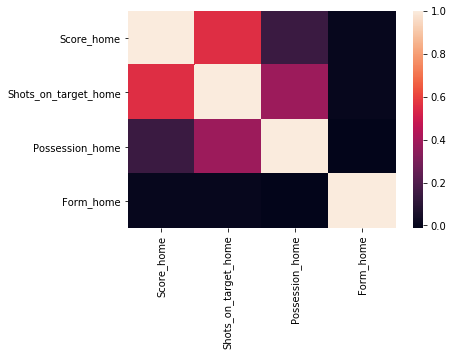

In [86]:
corr = df_form[['Score_home', 'Shots_on_target_home','Possession_home','Form_home']].corr()
_ = sns.heatmap(corr)

### Testing of Full Model
Now, just for completeness and given we have a smaller dataset, we should fit a suite of full models and from there we can investigate potential performance gains. From the beginning we'll start with some general model and perform cross-validation & other steps later.

Let's now compare the models with and without form side-by-side.

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [89]:
clfs = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier(),
        KNeighborsClassifier(), GaussianNB(), MLPClassifier(), SVC()]

# first run without form feature
X = df_wo.values
y = df['target'].values

run_model_diagnostics(X, y, clfs)

{'LogisticRegression': [('score', 0.6513157894736842)],
 'RandomForestClassifier': [('score', 0.5734649122807017)],
 'GradientBoostingClassifier': [('score', 0.6337719298245614)],
 'KNeighborsClassifier': [('score', 0.47478070175438597)],
 'GaussianNB': [('score', 0.555921052631579)],
 'MLPClassifier': [('score', 0.5416666666666666)],
 'SVC': [('score', 0.4649122807017544)]}

In [91]:
clfs = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier(),
        KNeighborsClassifier(), GaussianNB(), MLPClassifier(), SVC()]

df_form_dropped = df.drop(columns = FEATURES_TO_DROP)
X = df_form_dropped.values
y = df['target'].values

run_model_diagnostics(X, y, clfs)

{'LogisticRegression': [('score', 0.6513157894736842)],
 'RandomForestClassifier': [('score', 0.5570175438596491)],
 'GradientBoostingClassifier': [('score', 0.6348684210526315)],
 'KNeighborsClassifier': [('score', 0.47478070175438597)],
 'GaussianNB': [('score', 0.555921052631579)],
 'MLPClassifier': [('score', 0.4649122807017544)],
 'SVC': [('score', 0.4649122807017544)]}

No matter the model class, there is either a minimal difference or a negative impact (`RandomForest` and `MLP`). Given that both these models use some tree/graph structure it could be due to the proxying nature of the `form` feature and the others. So, going forward there does not seem to exist a benefit to including it.

### Feature Set Reduction
With all the above analysis, we can settle on our final feature list. We'll use this going forward in a somewhat different model. Again, this analysis is important because it allows us to simplify our model that will, likely, aid in avoiding making an unnecessarily complex model which will become more important once we begin simulating results on purely synthetic data.

## Expected Goals
The real idea, here, though is to generate a model that predicts the number of goals scored by each team within a single game. From there, of course, we can make predictions about who will win. I.e. now the function of interest becomes:

$$
team\,features\mapsto goals
$$

We can consider both transfer market spending along with the game-level statistics discussed above as team features. These should (if our logic is sound) form a generating function for goals within a game. With such a function, we can make predictions and, even, simulations over a period of time.

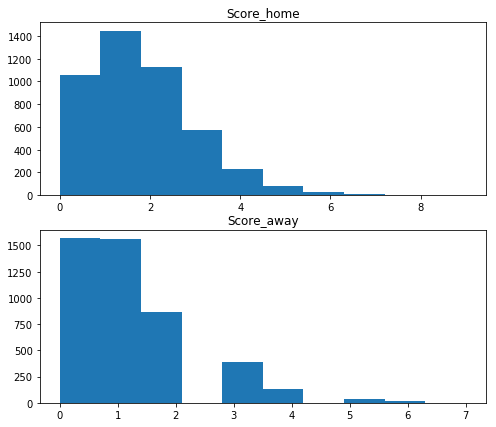

In [92]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8,7))

ax1.hist(df.Score_home)
ax1.set_title("Score_home")
ax2.hist(df.Score_away)
_ = ax2.set_title("Score_away")

Neither of these look like a normal distribution. If anything, and this makes intuitive sense, they appear to be following an exponential or Poisson distribution. Both are used in various applications to predict waiting times of random, independent events. In a sense, a goal in a game is a pseudo-random event. If you've ever watched their occurence does not rely on the entire game but rather a very short passage of play. How can we use this knowledge to make predictions?
### Data Preparation

Now, in order to perform this analysis we'll need to melt out each individual game above such that each individual row consists of one team's result (i.e. there will be two rows per game).

In [81]:
# based on the extensive analysis above
FEATURES_TO_DROP = ['Shots_home', 'Shots_away', 'Touches_home', 'Possession_home', 'Possession_away',
                                 'Touches_away','Tackles_home', 'Tackles_away', 'Arrivals_home', 'Arrivals_away',
                                 'Departures_home', 'Departures_away', 'Corners_home', 'Corners_away',
                                 'Red_cards_home', 'Red_cards_away', 'Yellow_cards_home', 'Yellow_cards_away']
TARGET_PROXIES = ['MatchID', 'Team', 'year', 'Score']

In [82]:
df_c = df.drop(columns = FEATURES_TO_DROP)
print(list(df_c))

['MatchID', 'Home_team', 'Away_team', 'Score_home', 'Score_away', 'Shots_on_target_home', 'Shots_on_target_away', 'Passes_home', 'Passes_away', 'Clearances_home', 'Clearances_away', 'Offsides_home', 'Offsides_away', 'Fouls_conceded_home', 'Fouls_conceded_away', 'year', 'Expenditures_home', 'Income_home', 'Expenditures_away', 'Income_away', 'target']


In [83]:
home_attributes = ['MatchID', 'Home_team', 'year'] + [a for a in list(df_c) if 'home' in a]
away_attributes = ['MatchID', 'Away_team', 'year'] + [a for a in list(df_c) if 'away' in a]

print(home_attributes, '\n')
print(away_attributes)

['MatchID', 'Home_team', 'year', 'Score_home', 'Shots_on_target_home', 'Passes_home', 'Clearances_home', 'Offsides_home', 'Fouls_conceded_home', 'Expenditures_home', 'Income_home'] 

['MatchID', 'Away_team', 'year', 'Score_away', 'Shots_on_target_away', 'Passes_away', 'Clearances_away', 'Offsides_away', 'Fouls_conceded_away', 'Expenditures_away', 'Income_away']


In [84]:
melted = []

for _, row in df_c.iterrows():
    home_team = [row[attr] for attr in away_attributes] + [1]
    away_team = [row[attr] for attr in home_attributes] + [0]
    melted.append(home_team)
    melted.append(away_team)

print(melted[0])

[5567, 'Aston Villa', 2007, 1, 3, 232, 51, 6, 19, 28.16, 2.08, 1]


In [85]:
features = ['MatchID', 'Team', 'year'] + [a.split('_')[0] for a in list(df_c) if 'home' in a] + ['IsHome']
print(features)

['MatchID', 'Team', 'year', 'Score', 'Shots', 'Passes', 'Clearances', 'Offsides', 'Fouls', 'Expenditures', 'Income', 'IsHome']


In [86]:
melted_df = pd.DataFrame(melted, columns = features)
melted_df.head()

,MatchID,Team,year,Score,Shots,Passes,Clearances,Offsides,Fouls,Expenditures,Income,IsHome
0,5567,Aston Villa,2007,1,3,232,51,6,19,28.16,2.08,1
1,5567,Arsenal,2007,1,7,631,14,2,10,17.10,14.85,0
2,5568,Spurs,2007,0,2,427,43,1,22,69.54,44.06,1
3,5568,Bolton,2007,2,4,243,20,3,22,19.38,4.39,0
4,5569,Watford,2007,1,7,321,32,1,15,11.97,15.39,1


In [87]:
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, LassoLars, Ridge, BayesianRidge, SGDRegressor, LinearRegression
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor

In [88]:
regressors = [SVR(), MLPRegressor(), KNeighborsRegressor(), Lasso(), LassoLars(), Ridge(), BayesianRidge(),
              SGDRegressor(), AdaBoostRegressor(), ExtraTreesRegressor(), GradientBoostingRegressor(),
              RandomForestRegressor(), LinearRegression()]

In [89]:
melted_df_wo = melted_df.drop(columns = TARGET_PROXIES)

X = melted_df_wo.values
y = melted_df['Score'].values

rmse_dict = run_model_diagnostics(X, y, regressors, is_classification = False)

rmse_list = []
for k, v in rmse_dict.items():
    rmse_list.append( (k, v[0][1]) )
sorted(rmse_list, key = lambda x: x[1])

[('GradientBoostingRegressor', 1.0265744234666727),
 ('LinearRegression', 1.0336720216267545),
 ('Ridge', 1.0336730954757896),
 ('BayesianRidge', 1.0337748046046524),
 ('AdaBoostRegressor', 1.0909837967820353),
 ('MLPRegressor', 1.11775903548974),
 ('ExtraTreesRegressor', 1.118473020671656),
 ('RandomForestRegressor', 1.1212797327902657),
 ('Lasso', 1.1349840838327634),
 ('LassoLars', 1.282620230552026),
 ('SVR', 1.2925471843002752),
 ('KNeighborsRegressor', 1.2997911136453253),
 ('SGDRegressor', 150437644246824.44)]

Based on these results we'll do some further CV testing on Gradient Boosting, Ridge, Bayesian Ridge, and MLP.

In [39]:
from sklearn.model_selection import RandomizedSearchCV
goal_models_to_consider = {'gb': GradientBoostingRegressor(), 'ridge': Ridge(), 
                           'bridge': BayesianRidge(), 'mlp': MLPRegressor()}

In [54]:
ridge_params = {'alpha': [ 10 ** -i for i in range(0,8)]}

ridge_cv = RandomizedSearchCV(goal_models_to_consider['ridge'], ridge_params, cv = 5, n_jobs = -1)
_ = ridge_cv.fit(X, y)

In [51]:
bridge_params = {'alpha_1': [ 10 ** -i for i in range(0,8)],
                 'alpha_2': [ 10 ** -i for i in range(0,8)],
                 'lambda_1': [ 10 ** -i for i in range(0,8)],
                 'lambda_2': [ 10 ** -i for i in range(0,8)]}

bridge_cv = RandomizedSearchCV(goal_models_to_consider['bridge'], bridge_params, cv = 5, n_jobs = -1)
_ = bridge_cv.fit(X, y)

In [57]:
mlp_params = { 'activation' : ['identity', 'logistic', 'tanh', 'relu'],
               'alpha': [ 10 ** -i for i in range(-1,8)],
               'learning_rate': ['constant', 'adaptive']}

mlp_cv = RandomizedSearchCV(goal_models_to_consider['mlp'], mlp_params, cv = 5, n_jobs = -1, n_iter = 20)
_ = mlp_cv.fit(X,y)

In [56]:
gb_params = {'loss': ['ls', 'lad', 'huber'],
             'subsample': [0.2, 0.5, 1.0],
             'min_samples_split': [2, 5, 10],
             'max_depth': [3, 5, 7, 10]}

gb_cv = RandomizedSearchCV(goal_models_to_consider['gb'], gb_params, cv = 5, n_jobs = -1, n_iter = 20)
_ = gb_cv.fit(X,y)

In [58]:
join_cv_results(ridge_cv.cv_results_)

{'alpha': 1} :  0.3479
{'alpha': 0.1} :  0.3479
{'alpha': 0.01} :  0.3479
{'alpha': 0.001} :  0.3479
{'alpha': 0.0001} :  0.3479
{'alpha': 1e-05} :  0.3479
{'alpha': 1e-06} :  0.3479
{'alpha': 1e-07} :  0.3479


In [59]:
join_cv_results(bridge_cv.cv_results_)

{'lambda_2': 0.001, 'lambda_1': 1, 'alpha_2': 1e-06, 'alpha_1': 1} :  0.3479
{'lambda_2': 0.001, 'lambda_1': 0.1, 'alpha_2': 1e-06, 'alpha_1': 0.01} :  0.3479
{'lambda_2': 1e-06, 'lambda_1': 1, 'alpha_2': 1, 'alpha_1': 0.01} :  0.3479
{'lambda_2': 0.01, 'lambda_1': 1e-06, 'alpha_2': 0.0001, 'alpha_1': 1e-07} :  0.3479
{'lambda_2': 1, 'lambda_1': 1e-06, 'alpha_2': 1e-05, 'alpha_1': 0.1} :  0.3479
{'lambda_2': 0.001, 'lambda_1': 0.001, 'alpha_2': 1e-07, 'alpha_1': 1e-06} :  0.3479
{'lambda_2': 0.001, 'lambda_1': 1e-05, 'alpha_2': 0.001, 'alpha_1': 0.0001} :  0.3479
{'lambda_2': 0.1, 'lambda_1': 1e-07, 'alpha_2': 1e-05, 'alpha_1': 0.0001} :  0.3479
{'lambda_2': 0.1, 'lambda_1': 0.0001, 'alpha_2': 0.0001, 'alpha_1': 1} :  0.3479
{'lambda_2': 0.01, 'lambda_1': 0.1, 'alpha_2': 1e-05, 'alpha_1': 1e-07} :  0.3479


In [60]:
join_cv_results(gb_cv.cv_results_)

{'subsample': 0.5, 'min_samples_split': 10, 'max_depth': 3, 'loss': 'ls'} :  0.3487
{'subsample': 1.0, 'min_samples_split': 2, 'max_depth': 10, 'loss': 'huber'} :  0.2648
{'subsample': 0.2, 'min_samples_split': 2, 'max_depth': 10, 'loss': 'huber'} :  0.1915
{'subsample': 0.2, 'min_samples_split': 2, 'max_depth': 3, 'loss': 'lad'} :  0.3274
{'subsample': 0.5, 'min_samples_split': 10, 'max_depth': 5, 'loss': 'lad'} :  0.328
{'subsample': 0.2, 'min_samples_split': 5, 'max_depth': 10, 'loss': 'huber'} :  0.1999
{'subsample': 0.2, 'min_samples_split': 5, 'max_depth': 10, 'loss': 'lad'} :  0.2361
{'subsample': 1.0, 'min_samples_split': 10, 'max_depth': 5, 'loss': 'huber'} :  0.3308
{'subsample': 1.0, 'min_samples_split': 2, 'max_depth': 7, 'loss': 'lad'} :  0.2837
{'subsample': 0.2, 'min_samples_split': 10, 'max_depth': 3, 'loss': 'ls'} :  0.3429
{'subsample': 1.0, 'min_samples_split': 10, 'max_depth': 3, 'loss': 'ls'} :  0.3513
{'subsample': 1.0, 'min_samples_split': 5, 'max_depth': 3, 'los

In [61]:
join_cv_results(mlp_cv.cv_results_)

{'learning_rate': 'adaptive', 'alpha': 0.001, 'activation': 'logistic'} :  0.3296
{'learning_rate': 'constant', 'alpha': 0.0001, 'activation': 'tanh'} :  0.314
{'learning_rate': 'constant', 'alpha': 0.1, 'activation': 'logistic'} :  0.3354
{'learning_rate': 'adaptive', 'alpha': 1, 'activation': 'tanh'} :  0.3265
{'learning_rate': 'constant', 'alpha': 10, 'activation': 'logistic'} :  0.3065
{'learning_rate': 'constant', 'alpha': 1, 'activation': 'relu'} :  0.2462
{'learning_rate': 'constant', 'alpha': 0.001, 'activation': 'tanh'} :  0.3179
{'learning_rate': 'adaptive', 'alpha': 0.01, 'activation': 'logistic'} :  0.337
{'learning_rate': 'constant', 'alpha': 0.1, 'activation': 'tanh'} :  0.3096
{'learning_rate': 'adaptive', 'alpha': 0.0001, 'activation': 'logistic'} :  0.3341
{'learning_rate': 'adaptive', 'alpha': 10, 'activation': 'relu'} :  0.2727
{'learning_rate': 'constant', 'alpha': 0.01, 'activation': 'tanh'} :  0.3126
{'learning_rate': 'constant', 'alpha': 1e-05, 'activation': 'tan

Based on the above results, let's use a Gradient Boosting model using a huber loss function for our expected goals model.

## Season Simulation
Now that we have our game-stats and expected goals models constructed we are ready to move on to simulation. Over the course of a season, many random events compound to change the relative standings of each team. By using a random simulation over the course of a season we can generate the league table prior to any matches beginning.

In order to do this we will use the following methodology:
1. Pick a window of previous games from each team's portfolio (a window)
2. Predict the next game's game-level statistics for that team (e.g. Passes) based on those performances, subject to randomness by adding a random normal distribution on top of these predictions
3. From a simulated set of game-level statistics use our goal model to generate the expected goals within that game
4. Use the goals scored by each team to make a game result prediction

We'll use 10 as a default window. This essentially means that the last 10 games of the previous year will be used to predict the first game and from there the window will slide over.

In [90]:
WINDOW = 10
max(melted_df.year)

2018

In [91]:
# which teams were in the league that year?
unique_teams = melted_df[melted_df.year == 2018].Team.unique()
unique_teams

array(['Leicester', 'Arsenal', 'Man City', 'Brighton', 'Burnley',
       'Chelsea', 'Huddersfield', 'Crystal Palace', 'Stoke', 'Everton',
       'West Ham', 'Man Utd', 'Spurs', 'Newcastle', 'Swansea',
       'Southampton', 'Liverpool', 'Watford', 'Bournemouth', 'West Brom'],
      dtype=object)

In [92]:
goal_model = build_exp_goals_model(melted_df, GradientBoostingRegressor(loss = 'huber', max_depth = 7))

In [93]:
model_map = {'Shots': LinearRegression(),
             'Passes': Ridge(),
             'Clearances': GradientBoostingRegressor(),
             'Offsides': Ridge(),
             'Fouls': GradientBoostingRegressor()}

for feature, clf in model_map.items():
    model_map[feature] = build_game_stats_model(melted_df, clf, feature)

In [94]:
# now for each game in 2018 we have to simulate the match statistics & the resultant expected goals
# recall we're using 10 games of history 
# so we'll start with the 2017 games and append each game in 2018 one-by-one
simulated_df = melted_df[melted_df.year == 2017]
simulated_df.head()
print(simulated_df.Team.unique())

['Liverpool' 'Arsenal' 'Man Utd' 'Bournemouth' 'Swansea' 'Burnley'
 'West Ham' 'Chelsea' 'West Brom' 'Crystal Palace' 'Spurs' 'Everton'
 'Leicester' 'Hull' 'Sunderland' 'Man City' 'Stoke' 'Middlesbrough'
 'Watford' 'Southampton']


In [95]:
st_dev_map = { feature: np.std(melted_df[feature]) for feature in model_map.keys()}
# np.std(melted_df['Shots'])
print(st_dev_map)

{'Shots': 2.546931901038936, 'Passes': 115.3683159143939, 'Clearances': 14.842825213227448, 'Offsides': 1.8304938875131036, 'Fouls': 3.8904622989576456}


### Single Simulation Example

In [96]:
season_df = melted_df[melted_df.year == 2018].drop(columns = list(model_map.keys()) + ['Score'])
season_df.head()

,MatchID,Team,year,Expenditures,Income,IsHome
8352,22342,Leicester,2018,100.14,54.61,1
8353,22342,Arsenal,2018,174.25,178.07,0
8354,22343,Man City,2018,361.95,104.14,1
8355,22343,Brighton,2018,72.39,0.00,0
8356,22344,Burnley,2018,40.74,57.00,1


In [97]:
# now we'll use this dataframe to generate all the results
for row in season_df.iterrows():
    game = row[1]
    simulated_result = fit_game(game, simulated_df, model_map, goal_model, st_dev_map)
    simulated_df = simulated_df.append(simulated_result, ignore_index = True)
    
print(simulated_df.tail())

      MatchID       Team  year  Score     Shots      Passes  Clearances  \
1513    22719    Swansea  2018      1  6.898844  443.483357   52.636867   
1514    22720  Leicester  2018      0  2.189379  384.887981   52.218071   
1515    22720      Spurs  2018      1  2.705679  540.561700   19.388534   
1516    22721    Everton  2018      1  7.585858  599.294877   37.967685   
1517    22721   West Ham  2018      2  5.539022  195.645865   35.423089   

      Offsides      Fouls  Expenditures  Income  IsHome  
1513  4.465805  11.243041         83.66   92.45       0  
1514  2.355834   2.751796        100.14   54.61       1  
1515  4.103329  10.712828        138.51  118.33       0  
1516  1.116638  10.499177        231.65  144.19       1  
1517  1.874939  14.043996         64.75   78.69       0  


In [98]:
points = get_team_points(simulated_df)
sorted( points, key = lambda x: -x[1])

[('Chelsea', 90),
 ('Man City', 75),
 ('Everton', 71),
 ('Liverpool', 62),
 ('Stoke', 58),
 ('Man Utd', 55),
 ('Spurs', 52),
 ('Leicester', 51),
 ('Southampton', 51),
 ('Arsenal', 50),
 ('Crystal Palace', 50),
 ('West Ham', 49),
 ('Bournemouth', 49),
 ('Brighton', 46),
 ('Swansea', 45),
 ('Burnley', 40),
 ('Huddersfield', 37),
 ('Watford', 36),
 ('Newcastle', 29),
 ('West Brom', 27)]

### Full Run
Now we'll do 100 simulation runs to get some idea of where teams can potentially end up over the course of a season. It's important to know that there are incentives not just to outright winning the league. The top 4 teams each year get to participate in the UEFA Champions League in the subsequent season. This European-wide competition is not only presitigous but brings enormous financial rewards to the participating teams (through TV & gate revenue). Meanwhile, the worst 3 teams face the relegation to the lower league in English football, which could be something of a financial death note (at least given their likely squad salaries which would have to be slashed).

In [113]:
RUNS = 100

point_totals, positions = run_simulation(melted_df, RUNS, model_map, goal_model, st_dev_map)

In [114]:
# avg. table
sorted( [(team, sum(points)/len(points)) for team, points in point_totals.items()], key = lambda x: -x[1] )

[('Chelsea', 79.85),
 ('Man City', 71.27),
 ('Spurs', 67.61),
 ('Liverpool', 62.64),
 ('Everton', 62.57),
 ('Arsenal', 61.8),
 ('Man Utd', 58.36),
 ('Leicester', 53.03),
 ('Watford', 46.19),
 ('Stoke', 44.96),
 ('Southampton', 44.87),
 ('Burnley', 43.07),
 ('Swansea', 42.61),
 ('Crystal Palace', 41.63),
 ('West Ham', 41.6),
 ('Brighton', 39.99),
 ('West Brom', 39.74),
 ('Bournemouth', 39.24),
 ('Newcastle', 37.29),
 ('Huddersfield', 36.0)]

In [132]:
def calculate_winning_probability(positions):
    prob_of_winning = []
    for team, pos in positions.items():
        t = (team, pos.count(1)/len(pos))
        prob_of_winning.append(t)
    return prob_of_winning
    
def calculate_top_4_probability(positions):
    prob_of_top4 = []
    for team, pos in positions.items():
        top4_count = 0
        for p in pos:
            if p < 5:
                top4_count += 1
        t = (team, top4_count/len(pos))
        prob_of_top4.append(t)
    return prob_of_top4
    
def calculate_position_interval(positions):
    intervals = []
    for team, pos in positions.items():
        d = {'team': team, 'max_pos': min(pos), 
             'avg_pos': sum(pos)/len(pos), 'stdev_pos': round(np.std(pos),4)}
        intervals.append(d)
    return intervals

In [118]:
# winning probability table
sorted(calculate_winning_probability(positions), key = lambda x: -x[1])

[('Chelsea', 0.63),
 ('Man City', 0.16),
 ('Spurs', 0.08),
 ('Everton', 0.04),
 ('Liverpool', 0.04),
 ('Arsenal', 0.03),
 ('Man Utd', 0.02),
 ('Leicester', 0.0),
 ('Brighton', 0.0),
 ('Burnley', 0.0),
 ('Huddersfield', 0.0),
 ('Crystal Palace', 0.0),
 ('Stoke', 0.0),
 ('West Ham', 0.0),
 ('Newcastle', 0.0),
 ('Swansea', 0.0),
 ('Southampton', 0.0),
 ('Watford', 0.0),
 ('Bournemouth', 0.0),
 ('West Brom', 0.0)]

In [124]:
# top 4 probability table
sorted(calculate_top_4_probability(positions), key = lambda x: -x[1])

[('Chelsea', 0.96),
 ('Man City', 0.82),
 ('Spurs', 0.65),
 ('Everton', 0.46),
 ('Liverpool', 0.4),
 ('Arsenal', 0.39),
 ('Man Utd', 0.19),
 ('Leicester', 0.08),
 ('Stoke', 0.02),
 ('Watford', 0.02),
 ('Brighton', 0.01),
 ('Burnley', 0.0),
 ('Huddersfield', 0.0),
 ('Crystal Palace', 0.0),
 ('West Ham', 0.0),
 ('Newcastle', 0.0),
 ('Swansea', 0.0),
 ('Southampton', 0.0),
 ('Bournemouth', 0.0),
 ('West Brom', 0.0)]

In [135]:
pos_df = pd.DataFrame(calculate_position_interval(positions))
pos_df.set_index('team')

,avg_pos,max_pos,stdev_pos
team,,,
Leicester,8.45,3,3.0899
Arsenal,5.46,1,2.6093
Man City,3.02,1,1.9286
Brighton,14.75,4,3.6315
Burnley,13.12,5,3.7290
Chelsea,1.68,1,1.1391
Huddersfield,16.65,7,3.0311
Crystal Palace,13.91,5,3.7579
Stoke,12.57,4,3.7610


For comparison, the actual table from that year can be found [here](https://www.skysports.com/premier-league-table/2017).